# ✅ PASO A PASO — Autoencoder Convolucional con Imágenes de Flores (sklearn)

**Objetivo:** Entrenar un **autoencoder convolucional (CNN)** para **reconstruir imágenes** usando las imágenes de ejemplo que trae `scikit-learn` (`flower.jpg` y `china.jpg`).

Aprenderás a:
- Preparar un **minidataset** a partir de imágenes estáticas (aumentándolas ligeramente).
- Definir un **encoder** (Conv2D + MaxPooling) y un **decoder** (UpSampling + Conv2D).
- Entrenar y **visualizar** reconstrucciones *(original vs. reconstruida)*.

## Paso 0 — Imports y configuración

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_sample_image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow:", tf.__version__)

TensorFlow: 2.20.0


## Paso 1 — Cargar imágenes de ejemplo (sklearn) y preparar el minidataset
Redimensionamos a **64×64** y generamos variaciones sencillas (ligeros recortes/giros/brillo) para obtener un conjunto de entrenamiento pequeño pero útil.

In [2]:
# Cargar imágenes de ejemplo (RGB)
img1 = load_sample_image('flower.jpg').astype('float32') / 255.0
img2 = load_sample_image('china.jpg').astype('float32') / 255.0

# Convertir a tensores y redimensionar a 64x64
def prep(img):
    t = tf.convert_to_tensor(img)
    t = tf.image.resize(t, (64, 64))
    return t

img1 = prep(img1)
img2 = prep(img2)

# Aumentos simples para crear un minidataset
def augment(img):
    # transformaciones suaves para mantener el contenido
    x = img
    # recorte aleatorio leve
    x = tf.image.random_crop(tf.image.resize_with_crop_or_pad(x, 68, 68), size=(64,64,3))
    # flip horizontal aleatorio
    x = tf.image.random_flip_left_right(x)
    # ajuste de brillo leve
    x = tf.image.random_brightness(x, max_delta=0.05)
    return x

# Generamos N muestras combinando ambas imágenes
N = 600
imgs = []
for i in range(N):
    base = img1 if (i % 2 == 0) else img2
    imgs.append(augment(base))
dataset = tf.stack(imgs).numpy()
dataset.shape

(600, 64, 64, 3)

## Paso 2 — Crear *train/val/test* (70/15/15)

In [3]:
n = dataset.shape[0]
n_train = int(0.7 * n)
n_val   = int(0.15 * n)

x_train = dataset[:n_train]
x_val   = dataset[n_train:n_train+n_val]
x_test  = dataset[n_train+n_val:]

x_train.shape, x_val.shape, x_test.shape

((420, 64, 64, 3), (90, 64, 64, 3), (90, 64, 64, 3))

## Paso 3 — Definir el Autoencoder (Conv → MaxPool → UpSampling → Conv)
Arquitectura compacta pensada para 64×64×3.

In [4]:
latent_dim = 128

encoder = models.Sequential([
    layers.Input(shape=(64,64,3)),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),   # 32x32
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),   # 16x16
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),   # 8x8
    layers.Conv2D(latent_dim, (3,3), activation='relu', padding='same')  # 8x8xlatent_dim
], name="encoder")

decoder = models.Sequential([
    layers.Input(shape=(8,8,latent_dim)),
    layers.UpSampling2D((2,2)),   # 16x16
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),   # 32x32
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),   # 64x64
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.Conv2D(3, (3,3), activation='sigmoid', padding='same')  # reconstrucción en [0,1]
], name="decoder")

ae_input = layers.Input(shape=(64,64,3))
z = encoder(ae_input)
x_hat = decoder(z)
autoencoder = models.Model(ae_input, x_hat, name="autoencoder")

autoencoder.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Sequential)            │ (None, 8, 8, 128)      │       240,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Sequential)            │ (None, 64, 64, 3)      │       240,707 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481,539 (1.84 MB)

 Trainable params: 481,539 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

## Paso 4 — Entrenamiento (con EarlyStopping)

In [5]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")
]

history = autoencoder.fit(
    x_train, x_train,
    validation_data=(x_val, x_val),
    epochs=30,
    batch_size=32,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/30
14/14 - 4s - 264ms/step - loss: 0.0895 - val_loss: 0.0474
Epoch 2/30
14/14 - 2s - 131ms/step - loss: 0.0388 - val_loss: 0.0303
Epoch 3/30
14/14 - 2s - 133ms/step - loss: 0.0271 - val_loss: 0.0235
Epoch 4/30
14/14 - 2s - 129ms/step - loss: 0.0216 - val_loss: 0.0196
Epoch 5/30
14/14 - 2s - 128ms/step - loss: 0.0185 - val_loss: 0.0172
Epoch 6/30
14/14 - 2s - 124ms/step - loss: 0.0162 - val_loss: 0.0160
Epoch 7/30
14/14 - 2s - 124ms/step - loss: 0.0153 - val_loss: 0.0146
Epoch 8/30
14/14 - 2s - 124ms/step - loss: 0.0141 - val_loss: 0.0140
Epoch 9/30
14/14 - 2s - 124ms/step - loss: 0.0134 - val_loss: 0.0130
Epoch 10/30
14/14 - 2s - 125ms/step - loss: 0.0127 - val_loss: 0.0126
Epoch 11/30
14/14 - 2s - 124ms/step - loss: 0.0126 - val_loss: 0.0120
Epoch 12/30
14/14 - 2s - 124ms/step - loss: 0.0116 - val_loss: 0.0113
Epoch 13/30
14/14 - 2s - 123ms/step - loss: 0.0113 - val_loss: 0.0115
Epoch 14/30
14/14 - 2s - 123ms/step - loss: 0.0111 - val_loss: 0.0109
Epoch 15/30
14/14 - 2s - 123m

## Paso 5 — Curvas de pérdida
Una figura con la pérdida de entrenamiento y validación por época.

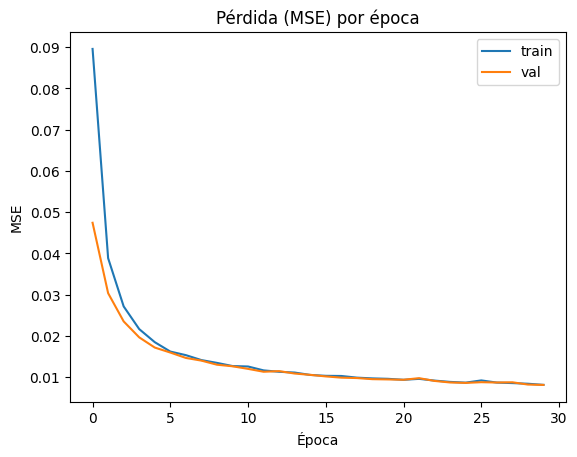

In [6]:
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Pérdida (MSE) por época")
plt.xlabel("Época")
plt.ylabel("MSE")
plt.legend()
plt.show()

## Paso 6 — Reconstrucciones: original vs reconstruida (muestras de test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.029245187..1.0007678].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0439994..0.9560006].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.025097942..0.97490203].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.03842633..1.009949].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03011067..0.96988934].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0049741156..1.0049741].


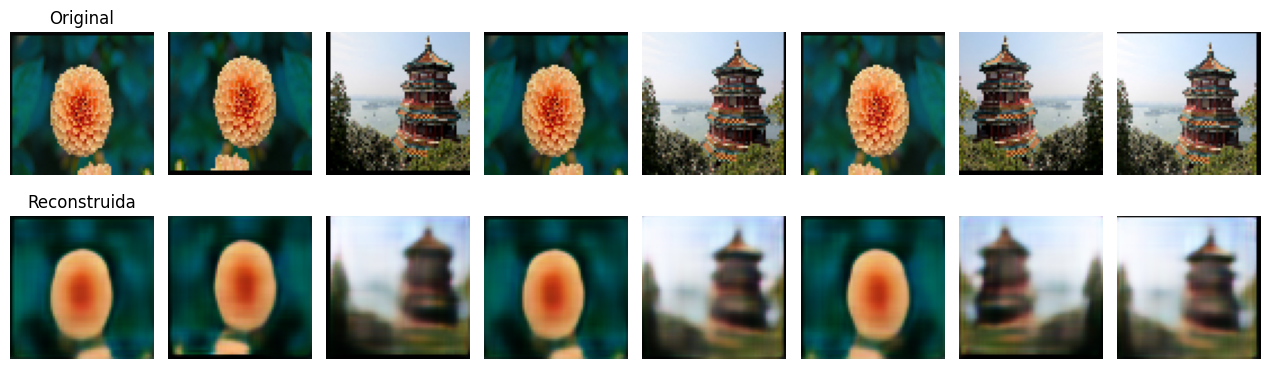

In [9]:
# Tomamos 8 ejemplos de test
idx = np.random.choice(len(x_test), size=8, replace=False)
samples = x_test[idx]
recons = autoencoder.predict(samples, verbose=0)

# Mostrar comparaciones
ncols = 8
plt.figure(figsize=(ncols*1.6, 4))
for i in range(ncols):
    # fila 1: original
    ax1 = plt.subplot(2, ncols, i+1)
    plt.imshow(samples[i])
    plt.axis('off')
    if i == 0:
        ax1.set_title("Original")
    # fila 2: reconstruida
    ax2 = plt.subplot(2, ncols, ncols+i+1)
    plt.imshow(recons[i])
    plt.axis('off')
    if i == 0:
        ax2.set_title("Reconstruida")
plt.tight_layout()
plt.show()

## Paso 7 — Conclusión didáctica

- El **encoder** comprime la información espacial (formas, colores predominantes), y el **decoder** la utiliza para reconstruir la imagen.  
- Las reconstrucciones tienden a ser **más suaves** que el original (se pierden detalles finos), lo que evidencia la **compresión**.  
- Con más datos o una arquitectura más profunda, la reconstrucción puede mejorar, pero cuidado con el **sobreajuste**.  
- Este mismo esquema puede extenderse a un **Denoising Autoencoder** añadiendo ruido a `x_train` y manteniendo como objetivo la imagen limpia.